## lab1 的改进版

2023/12/17:代码中其实有个很严重的错误,即性能是验证集的而非测试集。

/opt/homebrew/Caskroom/miniconda/base/envs/datasci/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


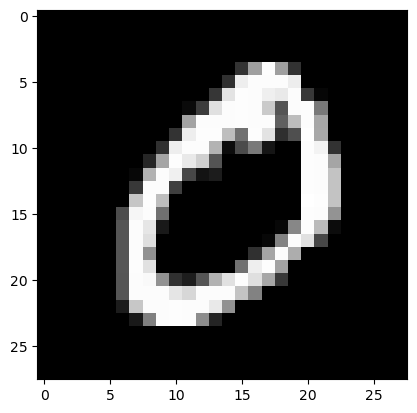

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold
from sklearn.metrics import accuracy_score

# 获取数据
data = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
pixel_values, targets = data
targets = targets.astype(int)
pixel_array = pixel_values.to_numpy()
single_image = pixel_array[1, :].reshape(28, 28)

# 展示图像
plt.imshow(single_image, cmap='gray')
plt.show()

In [4]:
def visualize_tsne(X, y):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=sns.color_palette("hls", 10), legend="full", alpha=0.8)
    plt.title('t-SNE visualization of MNIST data')
    plt.show()

In [5]:
# 使用 t-SNE 进行降维
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=25)
transformed_data = tsne.fit_transform(pixel_array)

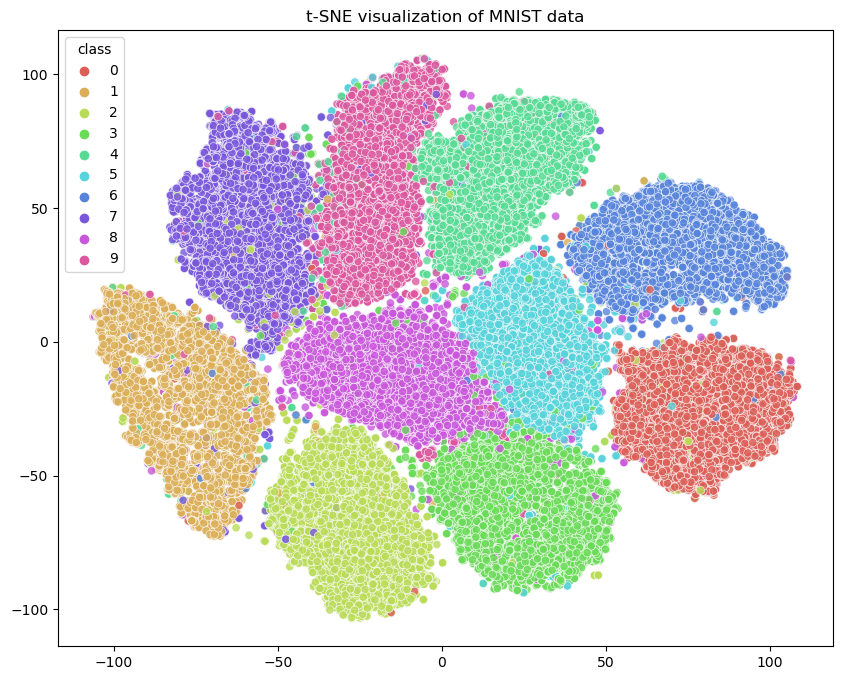

In [6]:
# 可视化降维后的数据
visualize_tsne(transformed_data, targets)

In [7]:
# 创建 DataFrame
tsne_df = pd.DataFrame(np.column_stack((transformed_data, targets)),
                       columns=["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

# 划分训练集和测试集
X_train = transformed_data[:60000]
y_train = targets[:60000]
X_test = transformed_data[60000:]
y_test = targets[60000:]

In [8]:
class GaussianNaiveBayes:
    def __init__(self):
        self.class_prior = None
        self.class_mean = None
        self.class_std = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # 初始化均值、标准差和先验概率
        self.class_prior = np.zeros(n_classes)
        self.class_mean = np.zeros((n_classes, n_features))
        self.class_std = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y==c]
            self.class_prior[idx] = X_c.shape[0] / float(n_samples)
            self.class_mean[idx, :] = X_c.mean(axis=0)
            self.class_std[idx, :] = X_c.std(axis=0)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # 计算高斯概率密度和后验概率
        for idx, c in enumerate(self.classes):
            prior = np.log(self.class_prior[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)
            
        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self.class_mean[class_idx]
        std = self.class_std[class_idx]
        numerator = np.exp(- (x-mean)**2 / (2 * std**2))
        # denominator = np.sqrt(2 * np.pi) * std
        denominator = np.sqrt(2 * np.pi) * (std + 1e-8)
        return numerator / denominator

In [9]:
# 使用朴素贝叶斯训练模型
clf = GaussianNaiveBayes()
clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = clf.predict(X_test)

In [10]:
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.10%
